<a id="top"></a>
# Landsat Vegetation Phenology

<hr>

# Notebook Summary

This notebook calculates vegetation phenology changes using Landsat 7 or Landsat 8 data. To detect changes in plant life for Landsat, the algorithm uses either the Normalized Difference Vegetation Index (NDVI) or the Enhanced Vegetation Index (EVI), which are common proxies for vegetation growth and health. The outputs of this notebook can be used to assess differences in agriculture fields over time or space and also allow the assessment of growing states such as planting and harvesting.  
<br>
There are two output products. The first output product is a time series boxplot of NDVI or EVI with the data potentially binned by week, month, week of year, or month of year. The second output product is a time series lineplot of the mean NDVI or EVI for each year, with the data potentially binned by week or month. This product is useful for comparing years to each other.
<br><br>
See this website for more information: https://phenology.cr.usgs.gov/ndvi_foundation.php

<hr>

# Index

* [Import Dependencies and Connect to the Data Cube](#import)
* [Choose Platforms and Products](#plat_prod)
* [Get the Extents of the Cube](#extents)
* [Define the Extents of the Analysis](#define_extents)
* [Load Data from the Data Cube and Obtain the Vegetation Proxy](#load_data)
* [Create Phenology Products](#phenology_products)
    * [Plot the Vegetation Index Over Time in a Box-and-Whisker Plot](#phenology_plot_1)
    * [Plot the Vegetation Index Over Time for Each Year](#phenology_plot_2)
* [Export Curve Fits to a CSV File](#export)
* [Show TIMESAT Stats](#timesat)

## <span id="import">Import Dependencies and Connect to the Data Cube [&#9652;](#top)</span> 

In [1]:
# Enable importing of utilities.
import sys
sys.path.append('..')

# Supress Warnings 
import warnings
warnings.filterwarnings('ignore')

import numpy as np  
import xarray as xr  
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt

# Load Data Cube Configuration
import datacube
import utils.data_cube_utilities.data_access_api as dc_api  
api = dc_api.DataAccessApi()
dc = api.dc

## <span id="plat_prod">Choose Platforms and Products [&#9652;](#top)</span>

**List available products for each platform**

In [2]:
# Get available products
products_info = dc.list_products()

# List Landsat 7 products
print("Landsat 7 Products:")
products_info[["platform", "name"]][products_info.platform == "LANDSAT_7"]

Landsat 7 Products:


,platform,name
id,,
12,LANDSAT_7,ls7_collections_sr_scene
13,LANDSAT_7,ls7_ledaps_ghana
17,LANDSAT_7,ls7_ledaps_kenya
18,LANDSAT_7,ls7_ledaps_senegal
16,LANDSAT_7,ls7_ledaps_sierra_leone
19,LANDSAT_7,ls7_ledaps_tanzania
31,LANDSAT_7,ls7_ledaps_vietnam


In [3]:
# List Landsat 8 products
print("Landsat 8 Products:")
products_info[["platform", "name"]][products_info.platform == "LANDSAT_8"]

Landsat 8 Products:


,platform,name
id,,
7,LANDSAT_8,ls8_collections_sr_scene
9,LANDSAT_8,ls8_lasrc_ghana
10,LANDSAT_8,ls8_lasrc_kenya
11,LANDSAT_8,ls8_lasrc_senegal
8,LANDSAT_8,ls8_lasrc_sierra_leone
15,LANDSAT_8,ls8_lasrc_tanzania


**Choose products**

<p style="color:red";><b>CHANGE INPUTS BELOW

In [4]:
# Select Products and Platforms
# It is possible to select multiple datasets (L7, L8)
# True = SELECT
# False = DO NOT SELECT

use_Landsat7 = False
use_Landsat8 = True
platforms, products = [], []
if use_Landsat7:
    platforms.append('LANDSAT_7')
    products.append('ls7_ledaps_ghana')
if use_Landsat8:
    platforms.append('LANDSAT_8')
    products.append('ls8_lasrc_ghana')

# Select a vegetation proxy to use to track changes in vegetation.
# Any one of ['NDVI', 'EVI'] may be chosen, 
# with 'NDVI' and 'EVI' calculating the spectral index of the same name.
veg_proxy = 'EVI' # 'NDVI' is recommended

## <span id="extents">Get the Extents of the Cube [&#9652;](#top)</span>

In [5]:
from utils.data_cube_utilities.dc_load import get_overlapping_area
from utils.data_cube_utilities.dc_time import dt_to_str

full_lat, full_lon, min_max_dates = get_overlapping_area(api, platforms, products)

# Print the extents of each product.
str_min_max_dates = np.vectorize(dt_to_str)(min_max_dates)
for i, (platform, product) in enumerate(zip(platforms, products)):
    print("For platform {} and product {}:".format(platform, product))
    print("Time Extents:", str_min_max_dates[i])
    print()

# Print the extents of the combined data.
min_start_date_mutual = np.max(min_max_dates[:,0])
max_end_date_mutual = np.min(min_max_dates[:,1])
print("Overlapping Extents:")
print("Latitude Extents:", full_lat)
print("Longitude Extents:", full_lon)
print("Time Extents:", list(map(dt_to_str, (min_start_date_mutual, max_end_date_mutual))))

For platform LANDSAT_8 and product ls8_lasrc_ghana:
Time Extents: ['2013-04-13' '2018-01-01']

Overlapping Extents:
Latitude Extents: (3.772924193304, 11.318772579912)
Longitude Extents: (-3.772924193304, 1.886462096652)
Time Extents: ['2013-04-13', '2018-01-01']


**Visualize the available area**

In [6]:
from utils.data_cube_utilities.dc_display_map import display_map
display_map(full_lat, full_lon)

## <span id="define_extents">Define the Extents of the Analysis [&#9652;](#top)</span>

<p style="color:red";><b>CHANGE INPUTS BELOW

In [7]:
# Select an analysis region (Lat-Lon) within the extents listed above. 
# Select a time period (Min-Max) within the extents listed above (Year-Month-Day)

# Tanzania Grassland / Cropland
# lat = (-4.5074, -4.4860) # North of Swaga Game Reserve
# lon = (35.1349, 35.1735) # North of Swaga Game Reserve

# Tanzania Grassland / Cropland
# lat = (-8.1541, -8.1272) # Southern Cropland 
# lon = (33.2016, 33.2545) # Southern Cropland

# Aviv Coffee Farm, Tanzania (small)
# lat = (-10.6999, -10.6959) 
# lon = (35.2608, 35.2662) 

# Aviv Coffee Farm, Tanzania (surrounding)
# lat = (-10.855, -10.560)
# lon = (35.130, 35.400)

# Soybean Fields in Western Kenya (from Kizito)
# lat = (-0.801180, -0.483689) # entire region
# lon = (34.193792, 34.546329) # entire region

# Vietnam
# lat = (10.9358, 11.0358)
# lon = (107.1899, 107.2899)

# Ghana
lat = (5.5813, 5.6004)
lon = (-0.5398, -0.5203)

# Time Period
start_date, end_date = dt.datetime(2014,1,1), dt.datetime(2018,12,31)
time_extents = (start_date, end_date)

**Visualize the selected area**

In [8]:
display_map(lat, lon)

## <span id="load_data">Load Data from the Data Cube and Obtain the Vegetation Proxy [&#9652;](#top)</span>

In [9]:
from utils.data_cube_utilities.dc_load import match_dim_sizes
from utils.data_cube_utilities.clean_mask import \
    landsat_qa_clean_mask, landsat_clean_mask_invalid
from utils.data_cube_utilities.sort import xarray_sortby_coord
from utils.data_cube_utilities.dc_load import is_dataset_empty

measurements = []
if veg_proxy == 'NDVI':
    measurements = ['red', 'nir', 'pixel_qa']
elif veg_proxy == 'EVI':
    measurements = ['red', 'blue', 'nir', 'pixel_qa']
datasets, clean_masks = {}, {}
matching_abs_res, same_dim_sizes = match_dim_sizes(dc, products, lon, lat)
for platform, product in zip(platforms, products):
    # Load the data.
    dataset = dc.load(platform=platform, product=product, lat=lat, lon=lon, 
                      time=time_extents, measurements=measurements)
    if len(dataset.dims) == 0: # The dataset is empty.
        continue
    # Get the clean masks.
    clean_mask = (landsat_qa_clean_mask(dataset, platform) & 
                  (dataset[measurements[0]] != -9999) & 
                  landsat_clean_mask_invalid(dataset))
    dataset = dataset.drop('pixel_qa')
    # If needed, scale the datasets and clean masks to the same size in the x and y dimensions.
    if not same_dim_sizes:    
        dataset = xr_scale_res(dataset, abs_res=matching_abs_res)
        clean_mask = xr_scale_res(clean_mask.astype(np.uint8), \
                                  abs_res=matching_abs_res).astype(np.bool)
    dataset = dataset.astype(np.float32).where(clean_mask)
    # Collect the dataset and clean mask.
    datasets[platform] = dataset
    clean_masks[platform] = clean_mask
# Combine everything.
if len(datasets) > 0:
    dataset = xarray_sortby_coord(
        xr.concat(list(datasets.values()), dim='time'), coord='time')
    clean_mask = xarray_sortby_coord(
        xr.concat(list(clean_masks.values()), dim='time'), coord='time')
else:
    dataset = xr.Dataset()
    clean_mask = xr.DataArray(np.empty((0,), dtype=np.bool))
del datasets, clean_masks

assert not is_dataset_empty(dataset), "The dataset is empty."

In [10]:
from utils.data_cube_utilities.dc_load import is_dataset_empty
from utils.data_cube_utilities.vegetation import NDVI, EVI

if veg_proxy == 'NDVI':
    dataset[veg_proxy] = NDVI(dataset)
if veg_proxy == 'EVI':
    dataset[veg_proxy] = EVI(dataset)

## <span id="phenology_products">Create Phenology Products[&#9652;](#top)</span>

If no plots appear in the figures below, there is no data available for the region selected.

### <span id="phenology_plot_1">Plot the Vegetation Index Over Time in a Box-and-Whisker Plot[&#9652;](#top)</span>

<p style="color:red";><b>CHANGE INPUTS BELOW

In [11]:
from utils.data_cube_utilities.plotter_utils import xarray_time_series_plot

# Specify whether to plot a curve fit of the vegetation index along time. Input can be either TRUE or FALSE
plot_curve_fit = True
assert isinstance(plot_curve_fit, bool), "The variable 'plot_curve_fit' must be "\
                                         "either True or False."

# Specify the target aggregation type of the curve fit. Input can be either 'mean' or 'median'.
curve_fit_target = 'median'
assert curve_fit_target in ['mean', 'median'], "The variable 'curve_fit_target' must be either "\
                                               "'mean' or 'median'."

# The maximum number of data points that appear along time in each plot.
# If more than this number of data points need to be plotted, a grid of plots will be created.
max_times_per_plot = 40 

<p style="color:red";><b>CHANGE INPUTS BELOW

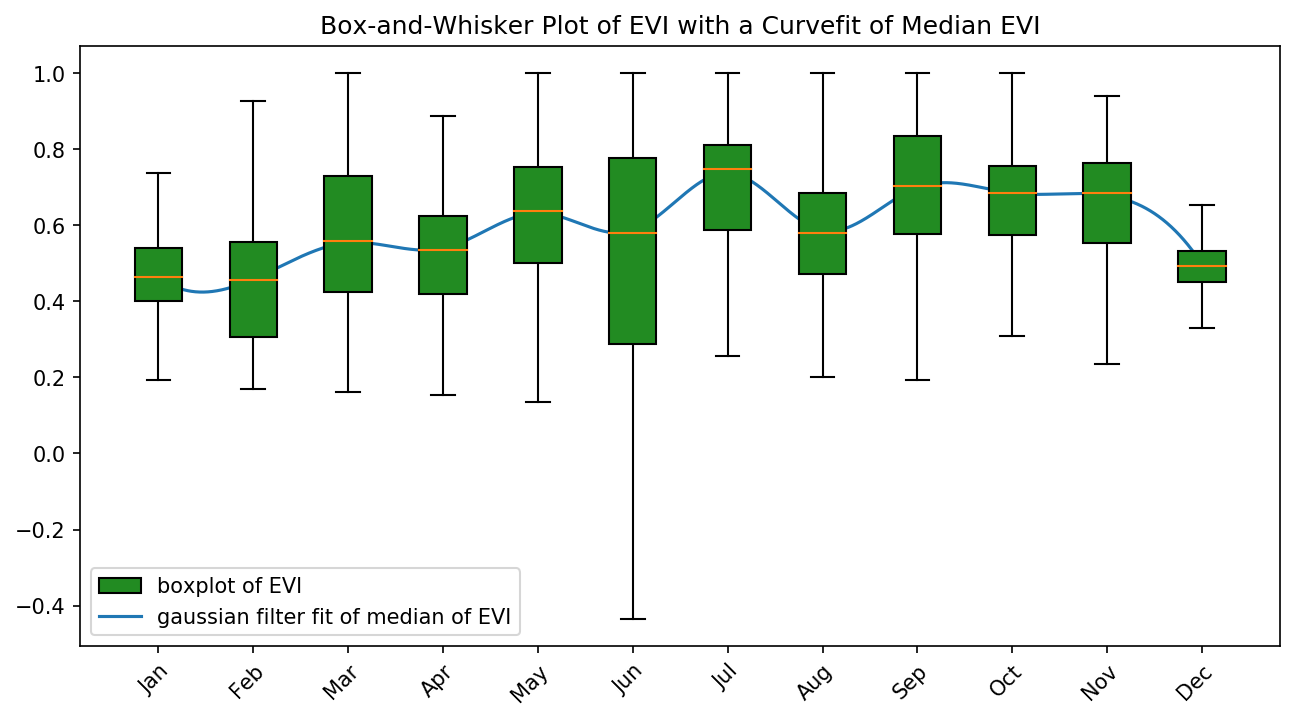

In [12]:
# Select the binning approach for the vegetation index. Set the 'bin_by' parameter.
# None          = do not bin the data
# 'week'        = bin the data by week with an extended time axis
# 'month'       = bin the data by month with an extended time axis
# 'weekofyear'  = bin the data by week and years using a single year time axis
# 'monthofyear' = bin the data by month and years using a single year time axis

# It is also possible to change some of the plotting features using the code below.

bin_by = 'monthofyear'
assert bin_by in [None, 'week', 'month', 'weekofyear', 'monthofyear'], \
    "The variable 'bin_by' can only have one of these values: "\
    "[None, 'week', 'month', 'weekofyear', 'monthofyear']"

aggregated_by_str = None
if bin_by is None:
    plotting_data = dataset
elif bin_by == 'week':
    plotting_data = dataset.resample(time='1w').mean()
    aggregated_by_str = 'Week'
elif bin_by == 'month':
    plotting_data = dataset.resample(time='1m').mean()
    aggregated_by_str = 'Month'
elif bin_by == 'weekofyear':
    plotting_data = dataset.groupby('time.week').mean(dim=('time'))
    aggregated_by_str = 'Week of Year'
elif bin_by == 'monthofyear':
    plotting_data = dataset.groupby('time.month').mean(dim=('time'))
    aggregated_by_str = 'Month of Year'
    
params = dict(dataset=plotting_data, plot_descs={veg_proxy:{'none':[
    {'box':{'boxprops':{'facecolor':'forestgreen'}}}]}})
if plot_curve_fit:
    params['plot_descs'][veg_proxy][curve_fit_target] = [{'gaussian_filter':{}}]
    
xarray_time_series_plot(**params, fig_params=dict(figsize=(8,4), dpi=150), 
                        max_times_per_plot=max_times_per_plot)
plt.title('Box-and-Whisker Plot of {0} with a Curvefit of Median {0}'.format(veg_proxy))
plt.show()

### <span id="phenology_plot_2">Plot the Vegetation Index Over Time for Each Year[&#9652;](#top)</span>
Note that the curve fits here do not show where some times have no data (encoded as NaNs), as is shown in the box-and-whisker plot. Notably, the curve fits interpolate over times with missing data that are not the first or last time (e.g. January or December for monthly binned data).

<p style="color:red";><b>CHANGE INPUTS BELOW

Year 2018 has no data, so will not be plotted.


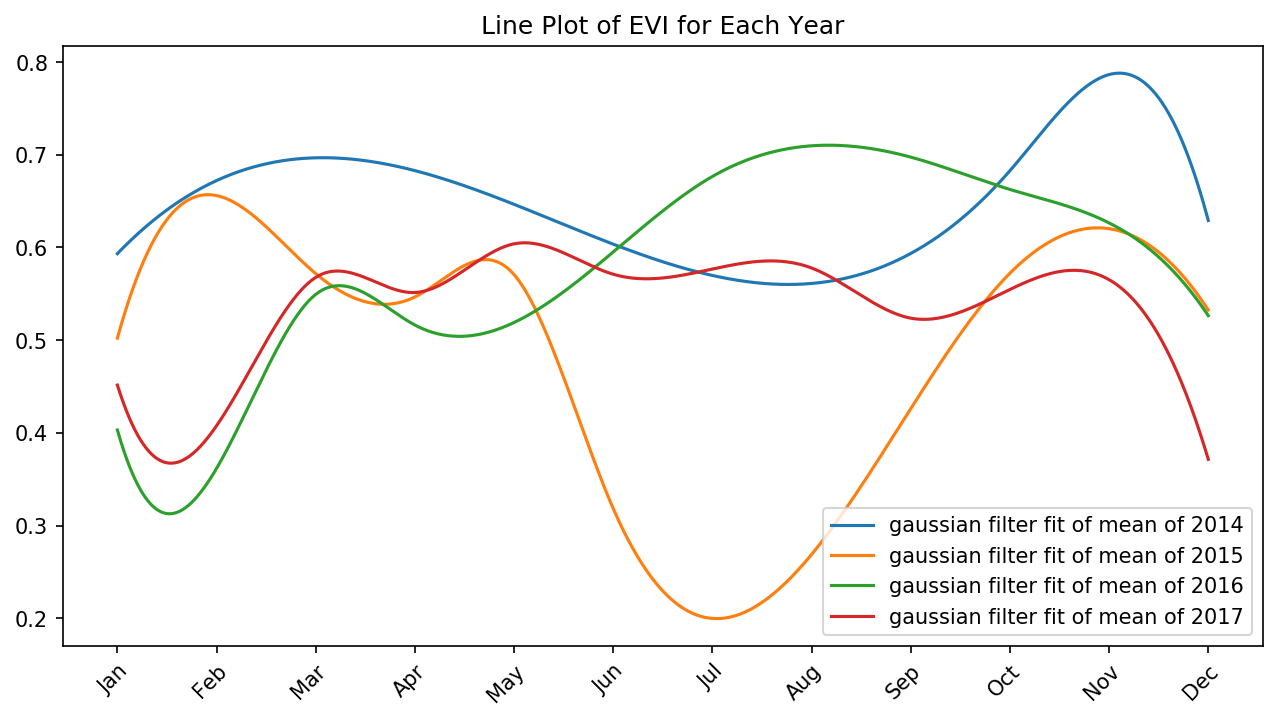

In [13]:
years_with_data = []
plot_descs = {}
daysofyear_per_year = {}
plotting_data_years = {}
time_dim_name = None
for year in range(start_date.year, end_date.year+1):
    year_data = dataset.sel(time=slice('{}-01-01'.format(year), '{}-12-31'.format(year)))[veg_proxy]
    if len(year_data['time']) == 0: # There is nothing to plot for this year.
        print("Year {} has no data, so will not be plotted.".format(year))
        continue
    years_with_data.append(year)
    
    spec_ind_dayofyear = year_data.groupby('time.dayofyear').mean()
    daysofyear_per_year[year] = spec_ind_dayofyear[~spec_ind_dayofyear.isnull()].dayofyear
    
# Select the binning approach for the vegetation index. Set the 'bin_by' parameter.
# 'weekofyear'  = bin the data by week and years using a single year time axis
# 'monthofyear' = bin the data by month and years using a single year time axis

    bin_by = 'monthofyear'
    
    assert bin_by in ['weekofyear', 'monthofyear'], \
        "The variable 'bin_by' can only have one of these values: "\
        "['weekofyear', 'monthofyear']"
    
    aggregated_by_str = None
    if bin_by == 'weekofyear':
        plotting_data_year = year_data.groupby('time.week').mean(dim=('time'))
        time_dim_name = 'week'
    elif bin_by == 'monthofyear':
        plotting_data_year = year_data.groupby('time.month').mean(dim=('time'))
        time_dim_name = 'month'

    plotting_data_years[year] = plotting_data_year
    num_time_pts = len(plotting_data_year[time_dim_name])
    
    # Select the curve-fit type. 
    # See the documentation for `xarray_time_series_plot()` regarding the `plot_descs` parameter.
    plot_descs[year] = {'mean':[{'gaussian_filter':{}}]}

time_dim_name = 'week' if bin_by == 'weekofyear' else 'month' if bin_by == 'monthofyear' else 'time'

num_times = 54 if bin_by == 'weekofyear' else 12
time_coords_arr = np.arange(1, num_times+1) # In xarray, week and month indices start at 1.
time_coords_da = xr.DataArray(time_coords_arr, coords={time_dim_name:time_coords_arr}, 
                              dims=[time_dim_name], name=time_dim_name)
coords = dict(list(plotting_data_years.values())[0].coords)
coords[time_dim_name] = time_coords_da 
plotting_data = xr.Dataset(plotting_data_years, coords=coords)
params = dict(dataset=plotting_data, plot_descs=plot_descs)

fig, curve_fit_plotting_data = \
    xarray_time_series_plot(**params, fig_params=dict(figsize=(8,4), dpi=150))
plt.title('Line Plot of {0} for Each Year'.format(veg_proxy))
plt.show()

### <span id="export">Export Curve Fits to a CSV File [&#9652;](#top)</span>

In [14]:
import os

# Convert the data to a `pandas.DataFrame`.
dataarrays = []
for (year, _, _), dataarray in curve_fit_plotting_data.items():
    dataarrays.append(dataarray.rename(year))
curve_fit_df = xr.merge(dataarrays).to_dataframe()

# Convert the month floats to day ints and average by day (scale to [0,1], multiply by 364, add 1).
curve_fit_df.index.values[:] = (364/11) * (curve_fit_df.index.values - 1) + 1
curve_fit_df.index = curve_fit_df.index.astype(int)
curve_fit_df.index.name = 'day of year'
curve_fit_df = curve_fit_df.groupby('day of year').mean()

# Export the data to a CSV.
csv_output_dir = 'output/CSVs/'
if not os.path.exists(csv_output_dir):
    os.makedirs(csv_output_dir)
curve_fit_df.to_csv(csv_output_dir + 'vegetation_phenology_yearly_curve_fits_landsat.csv')

### <span id="timesat">Show [TIMESAT](http://web.nateko.lu.se/timesat/timesat.asp) Stats [&#9652;](#top)</span>

In [15]:
def TIMESAT_stats(dataarray, time_dim='time'):
    """
    For a 1D array of values for a vegetation index - for which higher values tend to 
    indicate more vegetation - determine several statistics:
    1. Beginning of Season (BOS): The time index of the beginning of the growing season.
        (The downward inflection point before the maximum vegetation index value)
    2. End of Season (EOS): The time index of the end of the growing season.
        (The upward inflection point after the maximum vegetation index value)
    3. Middle of Season (MOS): The time index of the maximum vegetation index value.
    4. Length of Season (EOS-BOS): The time length of the season (index difference).
    5. Base Value (BASE): The minimum vegetation index value.
    6. Max Value (MAX): The maximum vegetation index value (the value at MOS).
    7. Amplitude (AMP): The difference between BASE and MAX.
    
    Parameters
    ----------
    dataarray: xarray.DataArray
        The 1D array of non-NaN values to determine the statistics for.
    time_dim: string
        The name of the time dimension in `dataarray`.

    Returns
    -------
    stats: dict
        A dictionary mapping statistic names to values.
    """
    assert time_dim in dataarray.dims, "The parameter `time_dim` is \"{}\", " \
        "but that dimension does not exist in the data.".format(time_dim)
    stats = {}
    data_np_arr = dataarray.values
    time_np_arr = dataarray[time_dim].values
    data_inds = np.arange(len(data_np_arr))
    
    # Obtain the first and second derivatives.
    fst_deriv = np.gradient(data_np_arr, time_np_arr)
    pos_fst_deriv = fst_deriv > 0
    neg_fst_deriv = 0 > fst_deriv
    snd_deriv = np.gradient(fst_deriv, time_np_arr)
    pos_snd_deriv = snd_deriv > 0
    neg_snd_deriv = 0 > snd_deriv
    
    # Determine MOS.
    # MOS is the index of the highest value immediately preceding a transition
    # of the first derivative from positive to negative.
    pos_to_neg_fst_deriv = pos_fst_deriv.copy()
    for i in range(len(pos_fst_deriv)):
        if i == len(pos_fst_deriv) - 1: # last index
            pos_to_neg_fst_deriv[i] = False
        elif pos_fst_deriv[i] and not pos_fst_deriv[i+1]: # + to -
            pos_to_neg_fst_deriv[i] = True
        else: # everything else
            pos_to_neg_fst_deriv[i] = False
    idxmos_potential_inds = data_inds[pos_to_neg_fst_deriv]
    idxmos_subset_ind = np.argmax(data_np_arr[pos_to_neg_fst_deriv])
    idxmos = idxmos_potential_inds[idxmos_subset_ind]
    stats['Middle of Season'] = idxmos
    
    data_inds_after_mos = np.roll(data_inds, len(data_inds)-idxmos-1)
    
    # Determine BOS.
    # BOS is the first negative inflection point of the positive values 
    # of the first derivative starting after and ending at the MOS.
    idxbos = data_inds_after_mos[np.argmax((pos_fst_deriv & neg_snd_deriv)[data_inds_after_mos])]
    stats['Beginning of Season'] = idxbos
    
    # Determine EOS.
    # EOS is the last positive inflection point of the negative values 
    # of the first derivative starting after and ending at the MOS.
    idxeos = data_inds_after_mos[np.argmax((neg_fst_deriv & pos_snd_deriv)[data_inds_after_mos][::-1])]
    stats['End of Season'] = idxeos
    
    # Determine EOS-BOS.
    stats['Length of Season'] = idxeos - idxbos
    # Determine BASE.
    stats['Base Value'] = data_np_arr.min()
    # Determine MAX.
    stats['Max Value'] = data_np_arr.max()
    # Determine AMP.
    stats['Amplitude'] = stats['Max Value'] - stats['Base Value']
    
    return stats

In [16]:
## Settings
# The minimum number of weeks or months with data for a year to have its stats calculated.
# The aggregation used to obtain the plotting data determines which of these is used.
min_weeks_per_year = 40
min_months_per_year = 9
## End Settings

for year, dataarray in plotting_data_years.items():
    dataarray = dataarray.mean(['latitude', 'longitude'])
    non_nan_mask = ~np.isnan(dataarray.values)
    num_times = non_nan_mask.sum()
    insufficient_data = False
    if bin_by == 'weekofyear':
        if num_times < min_weeks_per_year:
            print("There are {} weeks with data for the year {}, but the " \
                  "minimum number of weeks is {}.\n".format(num_times, year, min_weeks_per_year))
            continue
    elif bin_by == 'monthofyear':
        if num_times < min_months_per_year:
            print("There are {} months with data for the year {}, but the " \
                  "minimum number of months is {}.\n".format(num_times, year, min_months_per_year))
            continue
    # Remove NaNs for `TIMESAT_stats()`.
    dataarray = dataarray.sel({time_dim_name: dataarray[time_dim_name].values[non_nan_mask]})
    stats = TIMESAT_stats(dataarray, time_dim=time_dim_name)
    # Map indices to days of the year (can't use data from `daysofyear_per_year` directly
    # because `xarray_time_series_plot()` can have more points for smooth curve fitting.
    time_int_arr = dataarray[time_dim_name].values
    orig_day_int_arr = daysofyear_per_year[year].values
    day_int_arr = np.interp(time_int_arr, (time_int_arr.min(), time_int_arr.max()), 
                            (orig_day_int_arr.min(), orig_day_int_arr.max()))
    # Convert "times" in the TIMESAT stats from indices to days (ints).
    stats['Beginning of Season'] = int(round(day_int_arr[stats['Beginning of Season']]))
    stats['Middle of Season'] = int(round(day_int_arr[stats['Middle of Season']]))
    stats['End of Season'] = int(round(day_int_arr[stats['End of Season']]))
    stats['Length of Season'] = np.abs(stats['End of Season'] - stats['Beginning of Season']) 
    
    print("Year =", year)
    print("Beginning of Season (BOS) day =", stats['Beginning of Season'])
    print("End of Season (EOS) day =", stats['End of Season'])
    print("Middle of Season (MOS) day =", stats['Middle of Season'])
    print("Length of Season (abs(EOS-BOS)) in days =", stats['Length of Season'])
    print("Base Value (Min) =", stats['Base Value'])
    print("Max Value (Max) =", stats['Max Value'])
    print("Amplitude (Max-Min) =", stats['Amplitude'])
    print()

There are 5 months with data for the year 2014, but the minimum number of months is 9.

Year = 2015
Beginning of Season (BOS) day = 100
End of Season (EOS) day = 68
Middle of Season (MOS) day = 36
Length of Season (abs(EOS-BOS)) in days = 32
Base Value (Min) = 0.2950849
Max Value (Max) = 0.6666932
Amplitude (Max-Min) = 0.37160832

Year = 2016
Beginning of Season (BOS) day = 71
End of Season (EOS) day = 7
Middle of Season (MOS) day = 199
Length of Season (abs(EOS-BOS)) in days = 64
Base Value (Min) = 0.32128996
Max Value (Max) = 0.70215666
Amplitude (Max-Min) = 0.3808667

Year = 2017
Beginning of Season (BOS) day = 86
End of Season (EOS) day = 361
Middle of Season (MOS) day = 147
Length of Season (abs(EOS-BOS)) in days = 275
Base Value (Min) = 0.3705269
Max Value (Max) = 0.60420406
Amplitude (Max-Min) = 0.23367715

